In [1]:
from Simulation_PyAPDL import simulation_PyAPDL
from sklearn.cluster import DBSCAN
from scipy.stats import mode
from scipy.integrate import simps
import matplotlib.pyplot as plt
import scipy.io as sio
import numpy as np
import json
import os
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy.stats import spearmanr
from SALib.sample import sobol as sobol_sample
from SALib.analyze import sobol
from mpl_toolkits.mplot3d import Axes3D


def get_MAC(mode_shape_model,mode_shape_exp):
    mode_shape_model = mode_shape_model.reshape(1, -1)
    mode_shape_exp = mode_shape_exp.reshape(1, -1)
    return np.power(np.dot(mode_shape_exp,np.transpose(mode_shape_model)),2)[0][0]/(np.dot(mode_shape_model,np.transpose(mode_shape_model))[0][0]*np.dot(mode_shape_exp,np.transpose(mode_shape_exp)))[0][0]

def fit_gaussian_kernel(f,f_n,zeta):
    # Compute the standard deviation (sigma) based on the damping ratio
    band_width_ratio = 1.1
    sigma = band_width_ratio*(zeta * f_n) / np.sqrt(2 * np.log(2))
    return np.exp(-0.5 * ((f - f_n) / sigma)**2)

def find_peaks_SDOFsup(num_peak,natrual_freq_arr,frf_freq_arr,targer_FRF,zeta, plot_ = False):
    frf_freq_arr = frf_freq_arr.reshape(1,-1)[0]
    targer_FRF = targer_FRF.reshape(1,-1)[0]
   
    peak_list = np.zeros(num_peak)
    peak_freq_list = np.zeros(num_peak)
    peak_energy_list = np.zeros(num_peak)
    kernel = np.zeros(len(frf_freq_arr))
    kernel_current_best = np.zeros(len(frf_freq_arr))
    
    for i_peak in range(num_peak):
        energy_remain_arr = np.ones(len(natrual_freq_arr))
 
        for i_freq_n in range(len(natrual_freq_arr)):#
            freq_target = natrual_freq_arr[i_freq_n]
            ampl = np.interp(freq_target, frf_freq_arr, targer_FRF)
            kernel = np.maximum(kernel_current_best, ampl*fit_gaussian_kernel(frf_freq_arr,freq_target,zeta))

            signal_remain = targer_FRF - kernel
            energy_remain_arr[i_freq_n] = simps(signal_remain**2, frf_freq_arr)

        peak_energy_list[i_peak] = np.min(energy_remain_arr)
        peak_pos = np.argmin(energy_remain_arr)
        peak_list[i_peak] =  peak_pos
        peak_freq_list[i_peak]  = natrual_freq_arr[peak_pos]
        
        freq_current_best = natrual_freq_arr[peak_pos]
        ampl_current_best= np.interp(freq_current_best, frf_freq_arr, targer_FRF)
        kernel_current_best = np.maximum(kernel_current_best, ampl_current_best*fit_gaussian_kernel(frf_freq_arr,freq_current_best,zeta))

    if plot_:
        plt.plot(frf_freq_arr, targer_FRF,linestyle=":")
        plt.plot(frf_freq_arr, kernel_current_best,linestyle=":")
        plt.plot(frf_freq_arr, targer_FRF -kernel_current_best ,linestyle=":")
        plt.show()
    
    
    return np.sort(peak_list),np.sort(peak_freq_list)

def extract_mode_shape_vector(f_n_arr, frf_arr):
    ## Get mode shape from FRF
    i_model_1OG = np.array([ frf_arr['disp_ch9']['imag'].reshape(1,-1),
                            frf_arr['disp_ch10']['imag'].reshape(1,-1),
                            frf_arr['disp_ch11']['imag'].reshape(1,-1),
                            frf_arr['disp_ch12']['imag'].reshape(1,-1)])
    i_model_1OG_mat = np.vstack(i_model_1OG)
    max_i_1 = np.max(abs(i_model_1OG_mat))
    i_model_1OG_norm = i_model_1OG_mat/max_i_1

    i_model_2OG = np.array([ frf_arr['disp_ch3']['imag'].reshape(1,-1),
                            frf_arr['disp_ch13']['imag'].reshape(1,-1),
                            frf_arr['disp_ch14']['imag'].reshape(1,-1),
                            frf_arr['disp_ch15']['imag'].reshape(1,-1)])
    i_model_2OG_mat = np.vstack(i_model_2OG)
    max_i_2 = np.max(abs(i_model_2OG_mat))
    i_model_2OG_norm = i_model_2OG_mat/max_i_2

    f = frf_arr['disp_ch9']['freq'].reshape(1,-1)
    mode_shape_vector = np.zeros([len(f_n_arr),8])
    mode_freq_vector = np.zeros([len(f_n_arr)])

    i_mode = 0
    ampl_ratio = max_i_1/max_i_2
    for f_i_mode in f_n_arr:
        i_shape = 0
        mode_freq_vector[i_mode] = f_i_mode
        for i_mode_shape in range(4):
            mode_shape_1OG = np.interp(f_i_mode, f[0], i_model_1OG_norm[i_mode_shape,:])
            mode_shape_vector[i_mode,i_shape] = mode_shape_1OG
            i_shape = i_shape +1
            
        for i_mode_shape in range(4):
            mode_shape_2OG = np.interp(f_i_mode, f[0], i_model_2OG_norm[i_mode_shape,:]*ampl_ratio)
            mode_shape_vector[i_mode,i_shape] = mode_shape_2OG 
            i_shape = i_shape +1
        
        i_mode = i_mode +1

    return mode_freq_vector, mode_shape_vector

def mean_value_filted(data,std_dev_thres = 1):
    # Calculate the mean and standard deviation of the data
    mean = np.mean(data)
    std_dev = np.std(data)
    # Filter out outliers
    filtered_data = data[np.abs(data - mean) <= std_dev_thres * std_dev]

    if len(filtered_data) == 0:
        filtered_data = data
    # Calculate the mean of the remaining data
    return np.mean(filtered_data)

def find_max_cluster(data):
    # Reshape for clustering
    data_reshaped = data.reshape(-1, 1)
    # Apply DBSCAN for clustering
    db = DBSCAN(eps=1, min_samples=2).fit(data_reshaped)
    # Get cluster labels
    labels = db.labels_
    # Identify the largest cluster
    largest_cluster = mode(labels[labels != -1])[0][0]  # Exclude noise (-1)
    # Get values in the largest cluster
    return data[labels == largest_cluster]


## MMI :Improved finite element model updating of a full-scale steel bridge using sensitivity analysis　(Bjørn T. Svendsen, 2021)

def get_MMI(f_n_model,f_n_exp, mac, f_n_ratio=0.5):
    return(1-f_n_ratio)*mac - f_n_ratio* abs(f_n_exp-f_n_model)/f_n_exp

def split_data_limit_corr(input_X, input_Y, max_corr = 0.2, num_trial = 2000, test_size_ = 0.1, random_seed = None):
    for i_test in range(num_trial):
        bool_high_corr = False
        # Split into training and test sets
        if random_seed is None:
            seed = np.random.randint(0, 1000000)
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state=seed)

            # Compute Pearson and Spearman correlations for each feature
            correlations = []
            for i in range(input_X.shape[1]):
                pearson_corr = np.corrcoef(X_train[:, i][:X_test.shape[0]], X_test[:, i])[0, 1]
                spearman_corr, _ = spearmanr(X_train[:, i][:X_test.shape[0]], X_test[:, i])
                correlations.append((f"Feature {i+1}", pearson_corr, spearman_corr))
                if np.abs(pearson_corr) >= max_corr:
                    bool_high_corr = True
                    break

            if bool_high_corr:
                if i_test == num_trial-1:
                    print("Failed split data")
                continue
            else:
                print("Succesfully split data")
                print(f"Random seed {seed}")
                df = pd.DataFrame(correlations, columns=["Feature", "Pearson Corr", "Spearman Corr"])
                print(df)
                return X_train, X_test, y_train, y_test
        else:
            X_train, X_test, y_train, y_test = train_test_split(input_X, input_Y, test_size=test_size_, random_state = random_seed)
            return X_train, X_test, y_train, y_test
        
def sobol_GSA(gpr_model,num_var, sample_size = 2048, var_name = [], plot_ = False):
    # Define the problem (bounds of the input parameters)
    if var_name == []:
        problem = {
            'num_vars': 19,  # Number of parameters
            'names': ['param_{}'.format(i) for i in range(1, num_var+1)],  # Parameter names
            'bounds': [(0, 1)] * 19  # Parameter bounds, here [0, 1] for each
        }
    else:
        problem = {
            'num_vars': num_var,  # Number of parameters
            'names': [var_name[i] for i in range(0, num_var)],  # Parameter names
            'bounds': [(0, 1)] * num_var  # Parameter bounds, here [0, 1] for each
        }
    # Generate Sobol samples
    param_values = sobol_sample.sample(problem, sample_size)  
    Y = gpr_model.predict(param_values)
    # Perform Sobol analysis on the GP model's predictions
    Si = sobol.analyze(problem, Y, print_to_console=True)

    if plot_:
        # Create a figure and axis object
        fig, ax1 = plt.subplots(figsize=(12, 6))

        # Plot First-order Sobol indices (S1) on the left y-axis
        width = 0.35  # Width of the bars
        ax1.bar(var_name, Si['S1'], color='blue', label='First-order Sobol', alpha=0.7, width=width)
        ax1.set_xlabel('Parameters')
        ax1.set_ylabel('First-order Sobol indices', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        ax1.set_xticklabels(var_name, rotation=90)

        # Create the second y-axis for Total Sobol indices (ST)
        ax2 = ax1.twinx()
        ax2.bar(var_name, Si['ST'], color='lightcoral', label='Total Sobol', alpha=0.7, width=width, align='edge')
        ax2.set_ylabel('Total Sobol indices', color='lightcoral')
        ax2.tick_params(axis='y', labelcolor='lightcoral')

        # Align the bars by adjusting the y-limits to the same range
        y_min = min(min(Si['S1']), min(Si['ST']))
        y_max = max(max(Si['S1']), max(Si['ST']))
        ax1.set_ylim([y_min-0.05, y_max+0.1])
        ax2.set_ylim([y_min-0.05, y_max+0.1])
        # Set title and adjust layout
        plt.title('First-order and Total Sobol indices (Sensitivity Analysis)')
        plt.tight_layout()

        # Show the plot
        plt.show()
        
    return Si


def visualizeSurrogate3D(gpr_model, num_var, var1, var2,input_name = []):
    # Define the indices of the two variables you want to vary
    var1_index = var1  # Index for the 5th variable (Python is zero-indexed)
    var2_index = var2  # Index for the 10th variable

    if input_name == []:
        input_name = []
        for i in range(num_var):
            input_name.append(i)
    else:
        input_name


    # Calculate the mean of the remaining 17 variables
    mean_vars = 0.5*np.ones(num_var)


    # Generate a grid of values for var1 and var2 (these will vary, others are fixed)
    var1_grid, var2_grid = np.meshgrid(np.linspace(0, 1, 50),
                                    np.linspace(0, 1, 50))

    # Flatten the grids for var1 and var2 to create 1D arrays
    var1_flat = var1_grid.ravel()
    var2_flat = var2_grid.ravel()

    # Create a new input matrix for predictions
    # Stack the selected variables and tile the other variables' mean values
    X_grid = np.column_stack([  np.tile(mean_vars, (len(var1_flat), 1))])
    X_grid[:,var1_index] = var1_flat
    X_grid[:,var2_index] = var2_flat
    # Generate predictions for the grid (assuming gpr is your trained model)
    y_pred_grid = gpr_model.predict(X_grid).reshape(var1_grid.shape)

    # Now, y_pred_grid has shape (50, 50), matching the grid's shape

    # Create a 3D figure
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Surface plot

    surf = ax.plot_surface(var1_grid, var2_grid, y_pred_grid, cmap='viridis', alpha=0.8)
    #ax.scatter(var1, var2, y_test, c='red', label='Test Results', s=50)

    # Add labels and title
    ax.set_xlabel(f'X{var1_index + 1}: {input_name[var1_index]}')
    ax.set_ylabel(f'X{var2_index + 1}: {input_name[var2_index]}')
    ax.set_zlabel('Predicted Y')

    ax.set_title('3D Surface Plot of surrogate model')
    # Add color bar
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10)

    # Show the plot
    plt.show()



In [2]:
freq_resample = np.linspace(0, 50, 101)
num_doe = 1000
FRFs_simu = np.zeros([num_doe,24,len(freq_resample)])


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)
# Convert back to a NumPy array if needed
X = np.array(loaded_data)

directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI/"
for i_doe in range(num_doe):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]

    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)

    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_doe,i_ch_index,:] = imag_FRF
        
        i_ch_index = i_ch_index +1

directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex220/"
for i_doe in range(num_doe):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    i_ch_index = 8
    ch_list = [9,10,11,12,3,13,14,15]

    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)

    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_doe,i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1

directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex221/"
for i_doe in range(num_doe):
    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)
    i_ch_index = 16
    ch_list = [9,10,11,12,3,13,14,15]

    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)

    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_doe,i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1


FRFs_exp = np.zeros([24,len(freq_resample)])
i_pos_1OG = [9,10,11,12,3,13,14,15]
cut_freq_low = 4
cut_freq_high = 50

i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i,:] = i_resample

i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+8,:] = i_resample

i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+16,:] = i_resample

# Split into 3 groups of [8, 101]
num_groups = 3
group_size = 8
normalized_data = np.zeros_like(FRFs_exp)
#
for i in range(num_groups):
    # Get the current group
    start_idx = i * group_size
    end_idx = start_idx + group_size
    group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
    # Compute normalization value (e.g., max of the group)
    normalization_value = np.max(group)
    # Normalize the group
    normalized_data[start_idx:end_idx, :] = group / normalization_value
#FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
FRFs_exp_norm = normalized_data
#FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))

error_all = 1000*np.ones(1000)
for i_DOE in range(0,1000):
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    FRFs_simu_check = FRFs_simu[i_DOE,:,:]
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu_check[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
        #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
        FRFs_simu_norm = normalized_data

    error_all[i_DOE] = np.sum(np.power(FRFs_simu_norm - FRFs_exp_norm,2))

In [3]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex22 = mean_fn_1_exp
mean_fn_2_exp_ex22 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
i_doe = 1
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex22 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex22[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    i_ch_disp = [9,10,11,12,3,13,14,15]
    #i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.4 or mac_2_mean <= 0.4:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)
    
valid_X0_ex22 = X[i_doe_valid]
valid_Y1_ex22 = Fn_values_1[i_doe_valid]
valid_Y2_ex22 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex22, X1_test_ex22, y1_train_ex22, y1_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y1_ex22, random_seed=552430)
X2_train_ex22, X2_test_ex22, y2_train_ex22, y2_test_ex22 = split_data_limit_corr(valid_X0_ex22, valid_Y2_ex22, random_seed=653968)


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex22.fit(X1_train_ex22, y1_train_ex22)
# Predict on the test set
y_pred_fn1_ex22 = gpr_fn1_ex22.predict(X1_test_ex22)

# Initialize and train the GPR model
gpr_fn2_ex22 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex22.fit(X2_train_ex22, y2_train_ex22)
# Predict on the test set
y_pred_fn2_ex22 = gpr_fn2_ex22.predict(X2_test_ex22)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex22, y_pred_fn1_ex22)}, NMSE: {mean_squared_error(y1_test_ex22, y_pred_fn1_ex22) / np.var(y1_test_ex22)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex22, y_pred_fn2_ex22)}, NMSE: {mean_squared_error(y2_test_ex22, y_pred_fn2_ex22) / np.var(y2_test_ex22)}")
print(np.mean(energy_frf_ex22,axis=0))
print(np.std(energy_frf_ex22,axis=0))

1st natural freqeuncy: 12.1344, 2nd natural freqeuncy: 18.8672
gpr_fn1_ex22 performace: R² Score: 0.9827414875466709, NMSE: 0.017258512453329093
gpr_fn2_ex22 performace: R² Score: 0.976301974262981, NMSE: 0.02369802573701894
[5.02530788e-16 6.41526561e-17 3.67990489e-17 3.78867775e-17
 1.06090691e-15 8.56773731e-16 2.50726825e-15 1.32192214e-14]
[1.27977665e-15 1.39384501e-16 8.58310826e-17 8.54746060e-17
 1.71600769e-15 1.52086330e-15 4.17359007e-15 2.31717568e-14]


In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex220 = mean_fn_1_exp
mean_fn_2_exp_ex220 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")


# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex221/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex221 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex221[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex221 = X[i_doe_valid]
valid_Y1_ex221 = Fn_values_1[i_doe_valid]
valid_Y2_ex221 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex221, X1_test_ex221, y1_train_ex221, y1_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y1_ex221, random_seed=629684)
X2_train_ex221, X2_test_ex221, y2_train_ex221, y2_test_ex221 = split_data_limit_corr(valid_X0_ex221, valid_Y2_ex221, random_seed=645360)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex221.fit(X1_train_ex221, y1_train_ex221)
# Predict on the test set
y_pred_fn1_ex221 = gpr_fn1_ex221.predict(X1_test_ex221)

# Initialize and train the GPR model
gpr_fn2_ex221 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex221.fit(X2_train_ex221, y2_train_ex221)
# Predict on the test set
y_pred_fn2_ex221 = gpr_fn2_ex221.predict(X2_test_ex221)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex221, y_pred_fn1_ex221)}, NMSE: {mean_squared_error(y1_test_ex221, y_pred_fn1_ex221) / np.var(y1_test_ex221)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex221, y_pred_fn2_ex221)}, NMSE: {mean_squared_error(y2_test_ex221, y_pred_fn2_ex221) / np.var(y2_test_ex221)}")
print(np.mean(energy_frf_ex221,axis=0))
print(np.std(energy_frf_ex221,axis=0))

1st natural freqeuncy: 12.1856, 2nd natural freqeuncy: 19.200000000000003
296
gpr_fn1_ex22 performace: R² Score: 0.9747609213511622, NMSE: 0.025239078648837808
gpr_fn2_ex22 performace: R² Score: -14.811288203147571, NMSE: 15.811288203147571
[1.30916139e-16 3.64192216e-17 2.05856369e-17 1.33173493e-17
 3.43776563e-16 9.84229029e-16 1.70809832e-15 3.60583888e-15]
[3.33689810e-16 8.27070306e-17 5.11919029e-17 2.87800405e-17
 6.01932001e-16 1.82644452e-15 3.17960114e-15 6.44292351e-15]


In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
DOE_info = {}
i_doe_wrong = []
i_doe_valid = []

## Obtain the exp data
# Case 13
i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,3]
mode_2_exp = mode_shape_vector_exp[1::2,3]

mean_fn_1_exp_ex221 = mean_fn_1_exp
mean_fn_2_exp_ex221 = mean_fn_2_exp
print(f"1st natural freqeuncy: {mean_fn_1_exp}, 2nd natural freqeuncy: {mean_fn_2_exp}")

# Load the JSON file
directory = r"D:/MDSI_project/PCE_surrogate/InputData/Realization_frf_noSSI_ex220/"

MAC_values_1 = np.zeros(1000)
MAC_values_2 = np.zeros(1000)
Fn_values_1 = np.zeros(1000)
Fn_values_2 = np.zeros(1000)
MMI_1 = np.zeros(1000)
MMI_2 = np.zeros(1000)


# Load the JSON file
with open('lhs_data.json', 'r') as json_file:
    loaded_data = json.load(json_file)

# Convert back to a NumPy array if needed
X = np.array(loaded_data)

num_doe = 1000
energy_frf_ex220 = np.zeros([num_doe,8])

for i_doe in range(0,num_doe):

    filename = f"DOE_result_{i_doe}.json"
    full_path = os.path.join(directory, filename)

    ch_list = [9,10,11,12,3,13,14,15]
    with open(full_path, 'r') as json_file:
        loaded_data = json.load(json_file)
        #
    index_ch = 0
    for i_ch in ch_list:
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
        amplitude = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
        loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = amplitude 
        energy_frf_ex220[i_doe,index_ch] = np.sum(amplitude **2)
        index_ch = index_ch +1
    #
    meas_FRFs = loaded_data['meas_frf']
    #
    natrual_freq = []
    for i_mode in range(1,loaded_data['modal_info']['total_mode_num']+1):
        natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
    #
    mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
    #print(mode_freq_vector, mode_shape_vector)
    #
    #
    #i_ch_disp = [9,10,11,12,3,13,14,15]
    i_ch_disp = [9,15]
    mode_freq_1_list = np.zeros(len(i_ch_disp))
    mode_freq_2_list = np.zeros(len(i_ch_disp))
    mac_1_list = np.zeros(len(i_ch_disp))
    mac_2_list = np.zeros(len(i_ch_disp))
    #
    for i_ch in range(len(i_ch_disp)):
        [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05,plot_=False)
    
        mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
        mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
    #
    #print(mode_freq_1_list)
    #print(np.std(find_max_cluster(mode_freq_1_list)))
    #print(f_n_2_mean)
    f_n_1_mean = mean_value_filted((mode_freq_1_list),1)
    f_n_2_mean = mean_value_filted((mode_freq_2_list),1)

    #print(find_max_cluster(mode_freq_2_list))
    mac_1_mean = mean_value_filted(mac_1_list,1)
    mac_2_mean = mean_value_filted(mac_2_list,1)

    #print(mac_1_mean, mac_2_mean)
    MAC_values_1[i_doe] = mac_1_mean
    MAC_values_2[i_doe] = mac_2_mean
    Fn_values_1[i_doe] = f_n_1_mean
    Fn_values_2[i_doe] = f_n_2_mean
    MMI_1[i_doe] = get_MMI(f_n_1_mean,mean_fn_1_exp,mac_1_mean,0.7)
    MMI_2[i_doe] = get_MMI(f_n_2_mean,mean_fn_2_exp,mac_2_mean,0.7)
    if mac_1_mean <= 0.6 or mac_2_mean <= 0.5:
        i_doe_wrong.append(i_doe)
    else:
        i_doe_valid.append(i_doe)

print(len(i_doe_valid))
valid_X0_ex220 = X[i_doe_valid]
valid_Y1_ex220 = Fn_values_1[i_doe_valid]
valid_Y2_ex220 = Fn_values_2[i_doe_valid]

# Split into training and test sets
X1_train_ex220, X1_test_ex220, y1_train_ex220, y1_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y1_ex220, random_seed=765584)
X2_train_ex220, X2_test_ex220, y2_train_ex220, y2_test_ex220 = split_data_limit_corr(valid_X0_ex220, valid_Y2_ex220, random_seed=464463)
#507648 #385225  
#4581


# Define the kernel (adjust as needed)
kernel = C(1.0, (1e-3, 1e3)) * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))

# Initialize and train the GPR model
gpr_fn1_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn1_ex220.fit(X1_train_ex220, y1_train_ex220)
# Predict on the test set
y_pred_fn1_ex220 = gpr_fn1_ex220.predict(X1_test_ex220)

# Initialize and train the GPR model
gpr_fn2_ex220 = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, random_state=42)
gpr_fn2_ex220.fit(X2_train_ex220, y2_train_ex220)
# Predict on the test set
y_pred_fn2_ex220 = gpr_fn2_ex220.predict(X2_test_ex220)

print(f"gpr_fn1_ex22 performace: R² Score: {r2_score(y1_test_ex220, y_pred_fn1_ex220)}, NMSE: {mean_squared_error(y1_test_ex220, y_pred_fn1_ex220) / np.var(y1_test_ex220)}")
print(f"gpr_fn2_ex22 performace: R² Score: {r2_score(y2_test_ex220, y_pred_fn2_ex220)}, NMSE: {mean_squared_error(y2_test_ex220, y_pred_fn2_ex220) / np.var(y2_test_ex220)}")
print(np.mean(energy_frf_ex220,axis=0))
print(np.std(energy_frf_ex220,axis=0))

1st natural freqeuncy: 12.2112, 2nd natural freqeuncy: 18.8672
399
gpr_fn1_ex22 performace: R² Score: 0.9810381573215312, NMSE: 0.018961842678468753
gpr_fn2_ex22 performace: R² Score: 0.9426316370823559, NMSE: 0.05736836291764416
[8.38950090e-17 2.07774340e-17 1.53652408e-17 1.01941204e-17
 2.60217501e-16 4.37129159e-16 2.17211959e-15 2.16209439e-15]
[1.93070150e-16 4.28334812e-17 3.83769632e-17 2.02494022e-17
 4.07575513e-16 7.73079288e-16 4.08336670e-15 3.35373105e-15]


### Sensitivity analysis

                ST   ST_conf
t_sl      0.318079  0.024793
t_cor     0.005169  0.000457
t_g       0.000982  0.000102
t_ew      0.044470  0.003271
t_iw      0.009367  0.000657
e_sl      0.164682  0.011476
e_cor     0.001341  0.000148
e_g       0.001832  0.000183
e_ew      0.029055  0.002664
e_iw      0.007491  0.000643
rho_sl    0.412544  0.025854
rho_cor   0.000923  0.000095
rho_g     0.001113  0.000121
rho_ew    0.001307  0.000150
rho_iw    0.000833  0.000086
soil_vs   0.000788  0.000084
soil_rho  0.000984  0.000106
heig      0.044497  0.003861
DampR     0.000676  0.000078
                S1   S1_conf
t_sl      0.291897  0.034727
t_cor     0.004245  0.003940
t_g      -0.000097  0.001780
t_ew      0.040930  0.012648
t_iw      0.007337  0.005861
e_sl      0.161296  0.022602
e_cor    -0.000238  0.002023
e_g       0.003859  0.002641
e_ew      0.021219  0.011769
e_iw      0.002928  0.005209
rho_sl    0.403414  0.035331
rho_cor   0.000231  0.001804
rho_g     0.000199  0.002013
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_29000\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


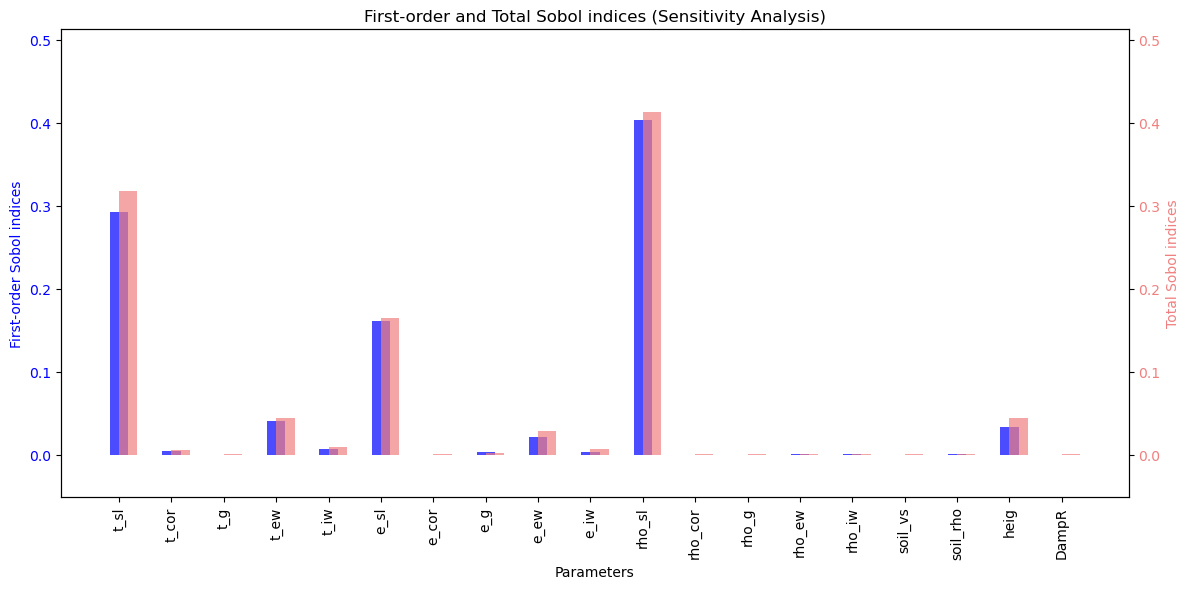

                ST   ST_conf
t_sl      0.463383  0.031390
t_cor     0.007040  0.000630
t_g       0.004815  0.000641
t_ew      0.014489  0.001318
t_iw      0.004402  0.000493
e_sl      0.195521  0.011928
e_cor     0.002789  0.000293
e_g       0.004528  0.000506
e_ew      0.005118  0.000515
e_iw      0.002673  0.000270
rho_sl    0.291005  0.018001
rho_cor   0.003731  0.000422
rho_g     0.002437  0.000303
rho_ew    0.003917  0.000484
rho_iw    0.003238  0.000374
soil_vs   0.003123  0.000356
soil_rho  0.002227  0.000273
heig      0.030005  0.002682
DampR     0.004796  0.000678
                S1   S1_conf
t_sl      0.440567  0.038855
t_cor     0.003292  0.005036
t_g       0.000087  0.004497
t_ew      0.009517  0.007861
t_iw     -0.000383  0.003363
e_sl      0.186134  0.026613
e_cor    -0.000325  0.003170
e_g      -0.004386  0.004822
e_ew      0.004216  0.004453
e_iw      0.000543  0.002797
rho_sl    0.273532  0.031070
rho_cor  -0.001224  0.003623
rho_g    -0.000695  0.002855
rho_ew   -0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_29000\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


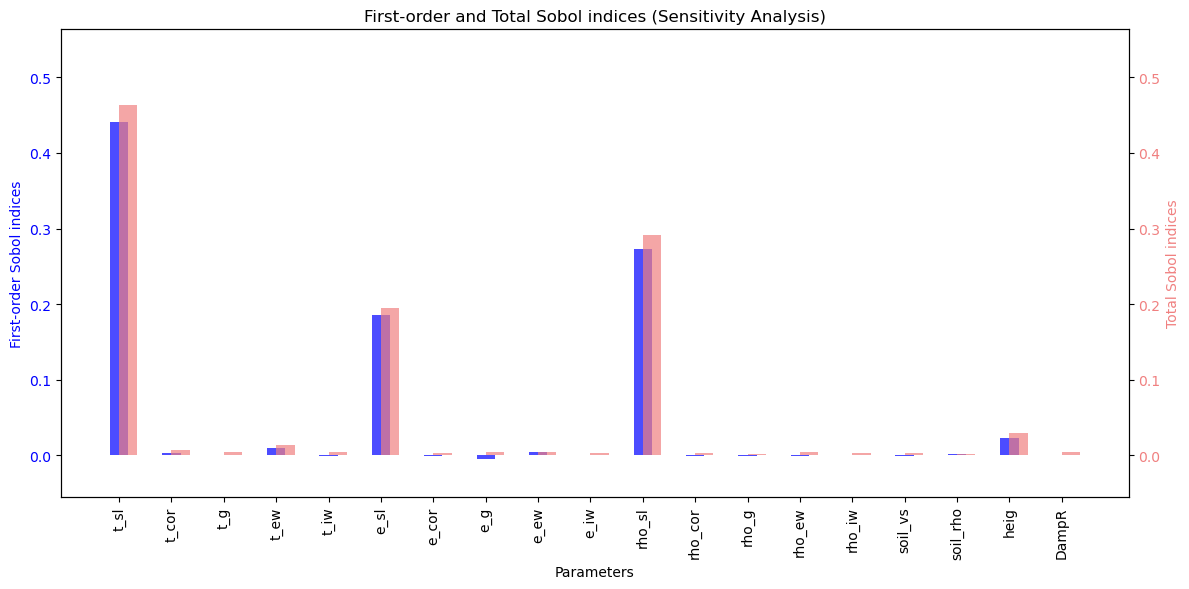

                ST   ST_conf
t_sl      0.212346  0.015656
t_cor     0.006589  0.000608
t_g       0.001335  0.000163
t_ew      0.053940  0.004284
t_iw      0.010135  0.001079
e_sl      0.164088  0.012420
e_cor     0.002653  0.000312
e_g       0.001984  0.000236
e_ew      0.035069  0.003125
e_iw      0.010136  0.000910
rho_sl    0.467973  0.030690
rho_cor   0.002188  0.000276
rho_g     0.002124  0.000260
rho_ew    0.002419  0.000269
rho_iw    0.001740  0.000190
soil_vs   0.001629  0.000191
soil_rho  0.003982  0.000467
heig      0.054906  0.003392
DampR     0.002181  0.000235
                S1   S1_conf
t_sl      0.202547  0.024126
t_cor     0.005608  0.005085
t_g      -0.000167  0.002457
t_ew      0.050907  0.014655
t_iw      0.008162  0.005924
e_sl      0.152313  0.023257
e_cor    -0.000492  0.003358
e_g       0.002764  0.003039
e_ew      0.023227  0.010599
e_iw      0.007654  0.006393
rho_sl    0.455585  0.036945
rho_cor   0.000616  0.002745
rho_g     0.000027  0.002844
rho_ew   -0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_29000\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


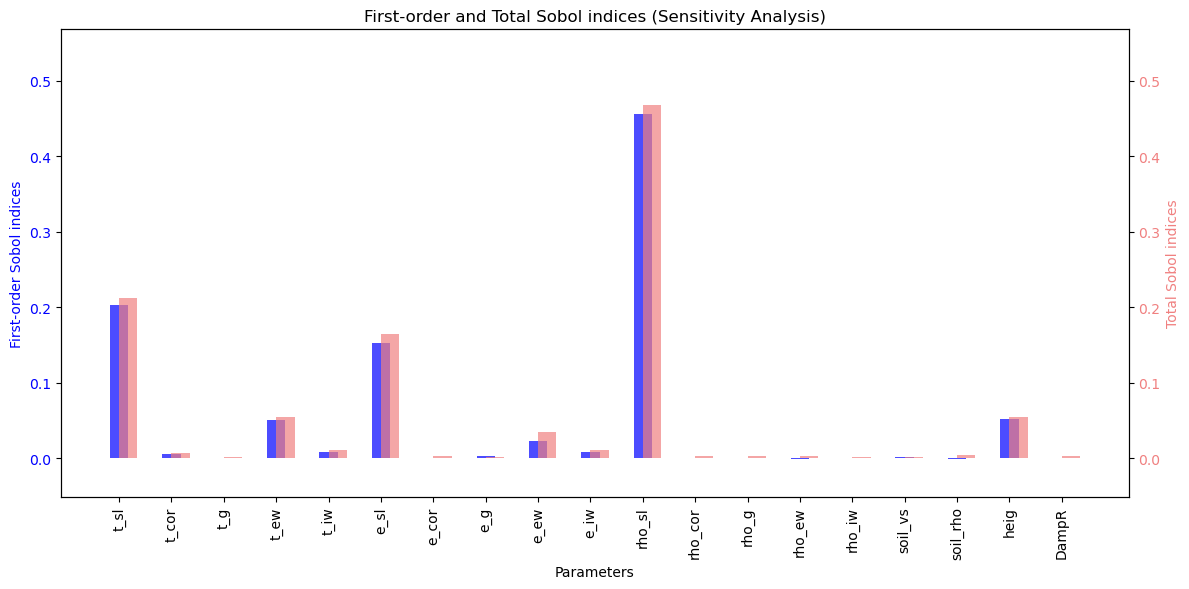

                ST     ST_conf
t_sl      0.327618    0.467892
t_cor     0.116095    0.726174
t_g       1.179391   15.488577
t_ew      0.358565    3.167868
t_iw      0.014975    0.129997
e_sl      0.089277    0.678118
e_cor     9.128272  106.435165
e_g       0.033825    0.068952
e_ew      0.334166    0.478078
e_iw      0.181650    1.252980
rho_sl    0.149513    0.211446
rho_cor   0.917604    5.290765
rho_g     0.157517    0.519070
rho_ew    0.448762    0.709407
rho_iw    0.066001    0.123407
soil_vs   0.416101    0.615641
soil_rho  0.108863    0.147680
heig      0.424761    0.696133
DampR     0.057066    0.117994
                S1   S1_conf
t_sl      0.000809  0.002374
t_cor    -0.000334  0.007339
t_g      -0.001378  0.017530
t_ew     -0.001454  0.011343
t_iw      0.000157  0.002284
e_sl      0.005578  0.014252
e_cor    -0.002453  0.035586
e_g       0.000311  0.001749
e_ew      0.000903  0.001877
e_iw     -0.000191  0.006230
rho_sl    0.000467  0.001094
rho_cor  -0.000389  0.012605
rho

C:\Users\v196m\AppData\Local\Temp\ipykernel_29000\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


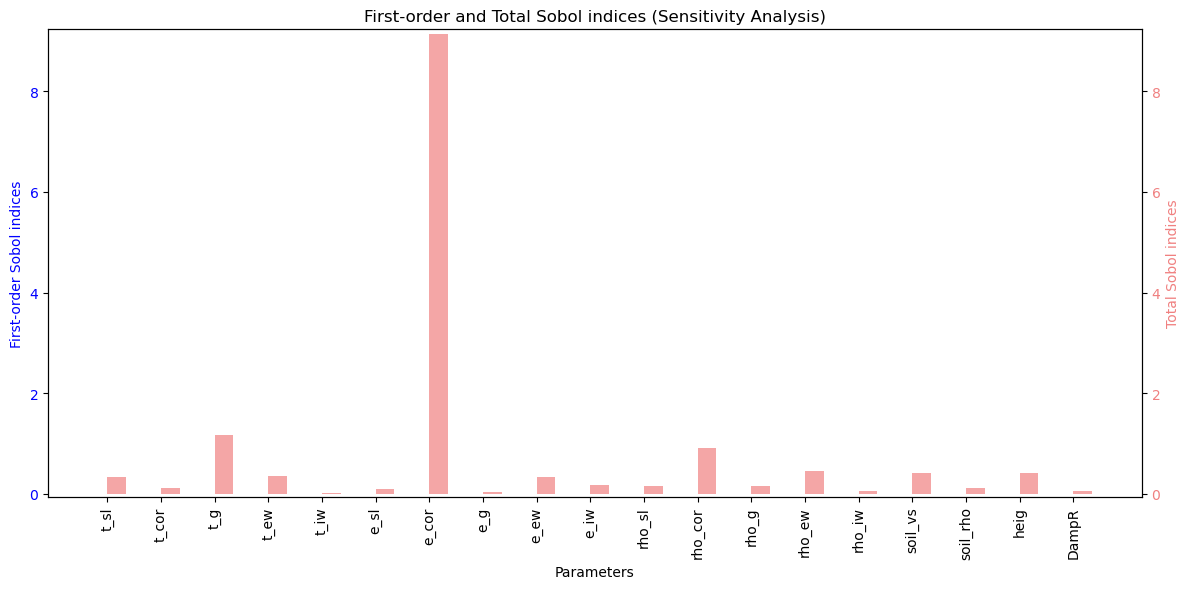

                ST   ST_conf
t_sl      0.271614  0.018327
t_cor     0.005107  0.000461
t_g       0.000854  0.000133
t_ew      0.050945  0.003776
t_iw      0.009106  0.000732
e_sl      0.149905  0.011428
e_cor     0.001278  0.000113
e_g       0.002293  0.000232
e_ew      0.027869  0.002310
e_iw      0.007328  0.000655
rho_sl    0.448650  0.026833
rho_cor   0.000896  0.000092
rho_g     0.001336  0.000150
rho_ew    0.001596  0.000212
rho_iw    0.001658  0.000171
soil_vs   0.001792  0.000217
soil_rho  0.001559  0.000170
heig      0.047986  0.004126
DampR     0.001603  0.000193
                S1   S1_conf
t_sl      0.258353  0.036151
t_cor     0.002506  0.004488
t_g       0.000058  0.002001
t_ew      0.047355  0.013188
t_iw      0.008207  0.005626
e_sl      0.144934  0.023281
e_cor    -0.000347  0.002147
e_g       0.000011  0.002964
e_ew      0.022506  0.009574
e_iw      0.009062  0.005953
rho_sl    0.438459  0.040970
rho_cor  -0.001499  0.002059
rho_g    -0.000106  0.002065
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_29000\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


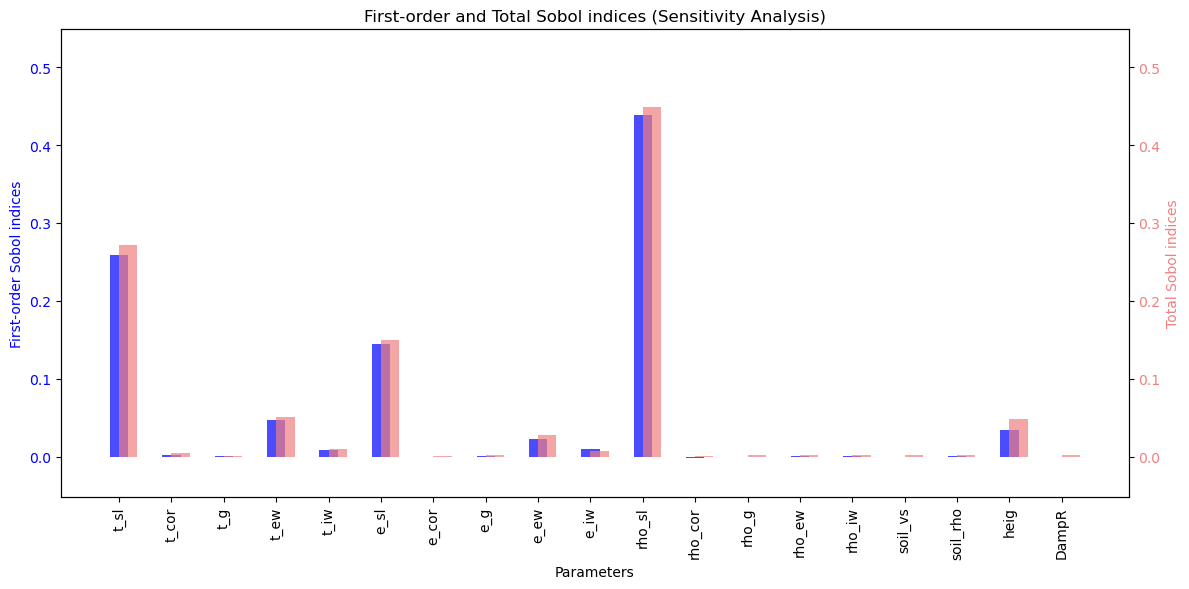

                ST   ST_conf
t_sl      0.513468  0.032059
t_cor     0.007077  0.000805
t_g       0.004662  0.000560
t_ew      0.009207  0.000808
t_iw      0.008467  0.000828
e_sl      0.175812  0.011248
e_cor     0.003871  0.000455
e_g       0.004008  0.000462
e_ew      0.005266  0.000595
e_iw      0.008412  0.001278
rho_sl    0.257381  0.019122
rho_cor   0.006114  0.000603
rho_g     0.004886  0.000510
rho_ew    0.011948  0.001370
rho_iw    0.002037  0.000244
soil_vs   0.003027  0.000320
soil_rho  0.002131  0.000208
heig      0.019614  0.001891
DampR     0.003037  0.000395
                S1   S1_conf
t_sl      0.505327  0.038820
t_cor     0.002537  0.004870
t_g      -0.000349  0.003888
t_ew      0.006120  0.005319
t_iw      0.005243  0.006547
e_sl      0.164888  0.022486
e_cor    -0.000723  0.003606
e_g       0.000688  0.004438
e_ew      0.000069  0.004714
e_iw      0.003413  0.004985
rho_sl    0.240601  0.031158
rho_cor   0.003267  0.004941
rho_g     0.002149  0.004493
rho_ew    0.00

C:\Users\v196m\AppData\Local\Temp\ipykernel_29000\2003193739.py:205: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(var_name, rotation=90)


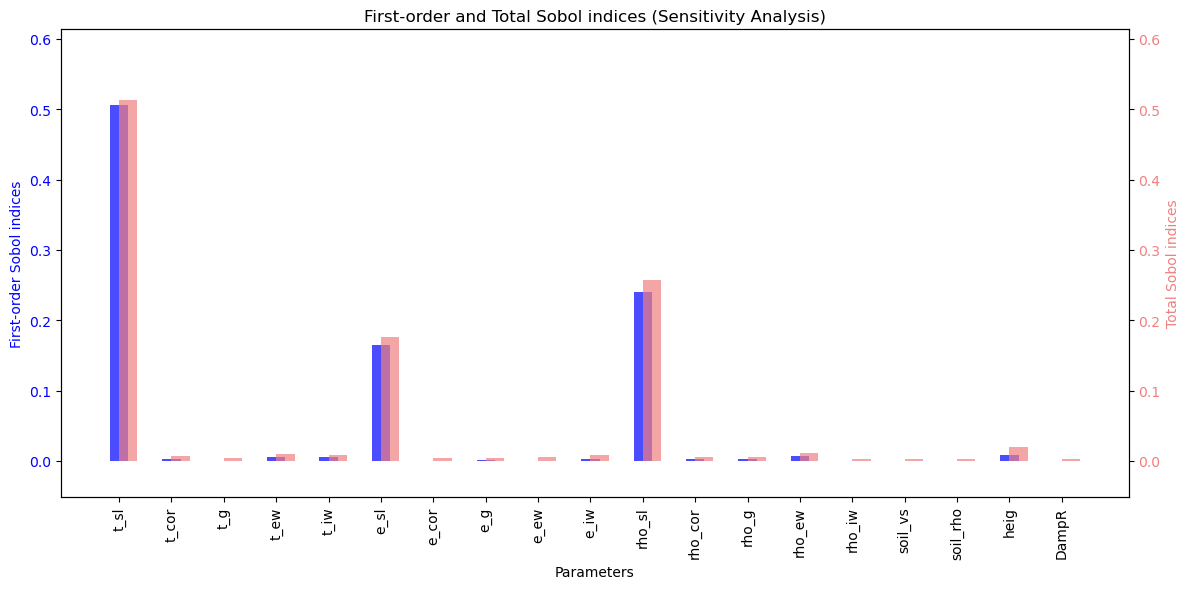

In [7]:
input_name = ['t_sl' ,'t_cor', 't_g', 't_ew', 't_iw',
              'e_sl' ,'e_cor', 'e_g', 'e_ew', 'e_iw',
              'rho_sl' ,'rho_cor', 'rho_g', 'rho_ew', 'rho_iw',
              'soil_vs' ,'soil_rho', 'heig', 'DampR']
Si_fn1_ex22 = sobol_GSA(gpr_fn1_ex22,19,2048,input_name,True)
Si_fn2_ex22 = sobol_GSA(gpr_fn2_ex22,19,2048,input_name,True)

Si_fn1_ex221 = sobol_GSA(gpr_fn1_ex221,19,2048,input_name,True)
Si_fn2_ex221 = sobol_GSA(gpr_fn2_ex221,19,2048,input_name,True)

Si_fn1_ex220 = sobol_GSA(gpr_fn1_ex220,19,2048,input_name,True)
Si_fn2_ex220 = sobol_GSA(gpr_fn2_ex220,19,2048,input_name,True)

### Optimization by GA

$x = argmin \sum_{i=1}^{3}(w_{1}^{i}*(f_{n1,gpr}^{i}-f_{n1,exp}^{i}))^2 + (w_{2}^{i}*(f_{n2,gpr}^{i}-f_{n2,exp}^{i}))^2 $ where $i$ indicates the index of impact tests.

$w_{1}^i = 100$ for $i = 1 \cdots 3$, 

$w_{2}^1 =  w_{2}^3 = 100$ and $w_{2}^2 = 50$ , 

In [10]:
import numpy as np
from scipy.optimize import minimize
from deap import base, creator, tools, algorithms
from scipy.stats import qmc

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x_):
    #x = np.array(x)
    x = 0.5*np.ones(19)
    x[0] = x_[0]
    x[3] = x_[1]
    x[4] = x_[2]
    x[5] = x_[3]
    x[8] = x_[4]
    x[9] = x_[5]
    x[10] = x_[6]
    x[17] = x_[7]
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    #fn1_pred_ex221 = surrogate_fn1_ex221(x)
    #fn2_pred_ex221 = surrogate_fn2_ex221(x)
    #return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(100*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (100*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2,)


bounds = [(0, 1) for _ in range(9)]  # Example bounds

# Remaining significant parameter: 0,3,4,5,8,10,15,16,17
# Using correlation: 0,3,5,8,9,10,17,18
#bounds[0 ]  = (0,1)
#bounds[3 ]  = (0,1)
#bounds[4 ]  = (0,1)
#bounds[5 ]  = (0,1)
#bounds[8 ]  = (0,1)
#bounds[10] = (0,1)
#bounds[15] = (0,1)
#bounds[16] = (0,1)
bounds[8] = (0.3,0.7)

# Define parameter bounds (example: [(low1, high1), (low2, high2), ...])
#bounds = [(0, 10), (50, 100), (0.1, 1.0)]  # Example bounds for each parameter
num_params = len(bounds)
population_size = 4000  # Define population size

# Generate LHS samples
sampler = qmc.LatinHypercube(d=num_params)  # d = number of parameters
lhs_samples = sampler.random(n=population_size+1)  # Generate population_size samples
scaled_samples = qmc.scale(lhs_samples, [b[0] for b in bounds], [b[1] for b in bounds])  # Scale to bounds

# Custom parameter generator using LHS
lhs_population = scaled_samples.tolist()  # Convert to a list of lists
print(np.shape(lhs_population))
def generate_individual():
    """Populates from the pre-generated LHS samples."""
    if not lhs_population:
        raise ValueError("LHS population is exhausted! Increase the number of samples.")
    return lhs_population.pop(0)

# Define the fitness function (minimization problem)
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))  # Minimize
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, generate_individual)  # Individual generator
toolbox.register("population", tools.initRepeat, list, toolbox.individual)  # Population generator

# Register genetic operators
toolbox.register("evaluate", objective_function)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=0.1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Population size and generations
population = toolbox.population(n=population_size)  # Population of 100 individuals

# Run the genetic algorithm
num_generations = 400
result_population, log = algorithms.eaSimple(population, toolbox, cxpb=0.7, mutpb=0.2, ngen=num_generations, 
                                             stats=None, halloffame=None, verbose=True)

# Evaluate all individuals and sort them
evaluated_population = [(ind, objective_function(ind)) for ind in result_population]
sorted_population = sorted(evaluated_population, key=lambda x: x[1])  # Sort by fitness

# Top 10 candidates
top_10_candidates = sorted_population[:30]

# Print the results
for idx, (candidate, score) in enumerate(top_10_candidates):
    print(f"Rank {idx+1}: Parameters = {candidate}, Objective = {score}")




(4001, 9)


c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\v196m\anaconda3\envs\opt2\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	4000  
1  	3048  
2  	3037  
3  	3026  
4  	3059  
5  	3036  
6  	3074  
7  	3035  
8  	3006  
9  	3003  
10 	3051  
11 	3035  
12 	3009  
13 	3047  
14 	2997  
15 	3020  
16 	3031  
17 	3078  
18 	3064  
19 	3008  
20 	3049  
21 	3012  
22 	3074  
23 	3078  
24 	3008  
25 	2950  
26 	3009  
27 	3086  
28 	3060  
29 	3016  
30 	3041  
31 	2996  
32 	3067  
33 	3016  
34 	3061  
35 	3002  
36 	3061  
37 	3028  
38 	3078  
39 	3042  
40 	3005  
41 	3094  
42 	3017  
43 	2998  
44 	3111  
45 	3066  
46 	3036  
47 	3082  
48 	2997  
49 	3032  
50 	2980  
51 	3031  
52 	3072  
53 	3037  
54 	3087  
55 	3076  
56 	3070  
57 	3063  
58 	3012  
59 	3027  
60 	3041  
61 	3059  
62 	3060  
63 	3027  
64 	3026  
65 	3041  
66 	3099  
67 	3021  
68 	3038  
69 	3003  
70 	3049  
71 	3042  
72 	3060  
73 	2967  
74 	2964  
75 	3057  
76 	3076  
77 	3067  
78 	3107  
79 	3053  
80 	3123  
81 	3000  
82 	3106  
83 	3083  
84 	3070  
85 	3097  
86 	3072  
87 	3026  
88 	3035  
89 	3048  

### OPtimization by L-BFGS-B

In [18]:
import numpy as np
from scipy.optimize import minimize

# Example surrogate models (replace with your actual GPR models)
def surrogate_fn1_ex22(inputs):
    # GPR model for fn1 (natural frequency 1)
    return gpr_fn1_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex22(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex22.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex220(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex220.predict(inputs.reshape(1, -1))[0]

def surrogate_fn1_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn1_ex221.predict(inputs.reshape(1, -1))[0]

def surrogate_fn2_ex221(inputs):
    # GPR model for fn2 (natural frequency 2)
    return gpr_fn2_ex221.predict(inputs.reshape(1, -1))[0]

# Objective function: minimize the difference from target
def objective_function(x):
    fn1_pred_ex22 = surrogate_fn1_ex22(x)
    fn2_pred_ex22 = surrogate_fn2_ex22(x)
    fn1_pred_ex220 = surrogate_fn1_ex220(x)
    fn2_pred_ex220 = surrogate_fn2_ex220(x)
    #fn1_pred_ex221 = surrogate_fn1_ex221(x)
    #fn2_pred_ex221 = surrogate_fn2_ex221(x)
    #return (100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (50*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2 +(1000*(fn1_pred_ex221 - mean_fn_1_exp_ex221))**2 + (1000*(fn2_pred_ex221 - mean_fn_2_exp_ex221))**2
    #return ((fn1_pred - 12.1344)**2) + ((fn2_pred - 18.8672)**2)
    return ((100*(fn1_pred_ex22 - mean_fn_1_exp_ex22))**2 + (100*(fn2_pred_ex22 - mean_fn_2_exp_ex22))**2 + (100*(fn1_pred_ex220 - mean_fn_1_exp_ex220))**2 + (100*(fn2_pred_ex220 - mean_fn_2_exp_ex220))**2)
# 
# Bounds for the 19 parameters (adjust as per your problem)
bounds = [(0.4, 0.6) for _ in range(19)]  # Example bounds

bounds[0]  = (0,1)
bounds[3]  = (0,1)
bounds[4]  = (0,1)
bounds[5]  = (0,1)
bounds[8]  = (0,1)
bounds[9]  = (0,1)
bounds[10] = (0,1)
bounds[15] = (0.5,0.5)
bounds[16] = (0.5,0.5)
bounds[17] = (0.4,0.6)


# Initial guess for the parameters
#x0 = np.random.uniform(0, 1 ,size=19)
id_ = 0
x0 = 0.5*np.ones(19)



x0[0]  = top_10_candidates[id_][0][0]
x0[3]  = top_10_candidates[id_][0][1]
x0[4]  = top_10_candidates[id_][0][2]
x0[5]  = top_10_candidates[id_][0][3]
x0[8]  = top_10_candidates[id_][0][4]
x0[10] = top_10_candidates[id_][0][5]
x0[15] = top_10_candidates[id_][0][6]
x0[16] = top_10_candidates[id_][0][7]
x0[17] = top_10_candidates[id_][0][8]

#x0 = top_10_candidates[5][0]

x_top_10_candidates = np.zeros([10,19])
print(x0)

for i_top in range(1):
    # Perform optimization
    result = minimize(objective_function, x0, bounds=bounds, method='L-BFGS-B')

    # Optimized parameters
    if result.success:
        optimized_params = result.x
        print("Optimized Parameters:", optimized_params)
        print("Objective Function Value:", result.fun)
        print(f"goal fn_1:{mean_fn_1_exp_ex22}, fn_2:{mean_fn_2_exp_ex22}")
        print(f"fn_1: {surrogate_fn1_ex22(result.x)}, fn_2: {surrogate_fn2_ex22(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex220}, fn_2:{mean_fn_2_exp_ex220}")
        print(f"fn_1: {surrogate_fn1_ex220(result.x)}, fn_2: {surrogate_fn2_ex220(result.x)}")
        print(f"goal fn_1:{mean_fn_1_exp_ex221}, fn_2:{mean_fn_2_exp_ex221}")
        print(f"fn_1: {surrogate_fn1_ex221(result.x)}, fn_2: {surrogate_fn2_ex221(result.x)}")
        x_top_10_candidates[i_top,:] = result.x
        
    else:
        print("Optimization failed:", result.message)

# Identify rows that are not all zeros
non_zero_rows = ~np.all(x_top_10_candidates == 0, axis=1)
# Remove rows with all zeros
x_top_10_candidates = x_top_10_candidates[non_zero_rows]
x_top_10_candidates = np.unique(x_top_10_candidates, axis=0)
print(x_top_10_candidates)


[9.21121056e-01 5.00000000e-01 5.00000000e-01 1.89823635e-01
 1.05428223e-01 8.35621396e-01 5.00000000e-01 5.00000000e-01
 2.29075811e-01 5.00000000e-01 1.05077589e+00 5.00000000e-01
 5.00000000e-01 5.00000000e-01 5.00000000e-01 8.82506681e-01
 6.93245311e-01 2.06883731e+06 5.00000000e-01]
Optimized Parameters: [0.93718216 0.54698004 0.55540268 0.22927281 0.16237968 0.84501231
 0.47868689 0.53591983 0.23035016 0.54626292 0.92440031 0.56086449
 0.49355294 0.52268942 0.51563848 0.5        0.5        0.57319976
 0.47168516]
Objective Function Value: 1.3988935940593212e-09
goal fn_1:12.1344, fn_2:18.8672
fn_1: 12.1344002681694, fn_2: 18.867200008730514
goal fn_1:12.1856, fn_2:19.200000000000003
fn_1: 12.185599749152445, fn_2: 19.199999929474735
goal fn_1:12.2112, fn_2:18.8672
fn_1: 12.138116598205585, fn_2: 0.0011269162775494523
[[0.93718216 0.54698004 0.55540268 0.22927281 0.16237968 0.84501231
  0.47868689 0.53591983 0.23035016 0.54626292 0.92440031 0.56086449
  0.49355294 0.52268942 0.5

(7, 19)


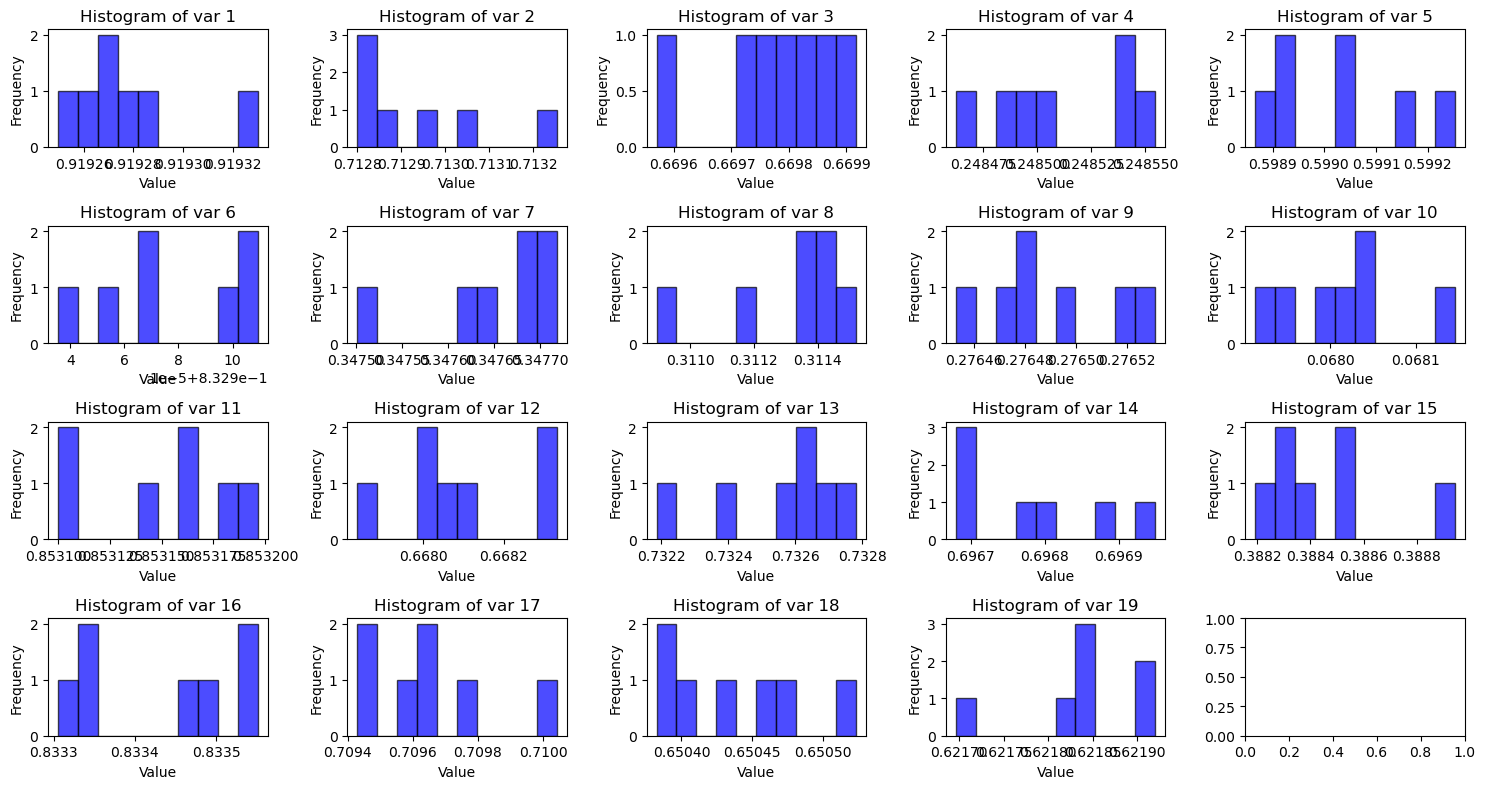

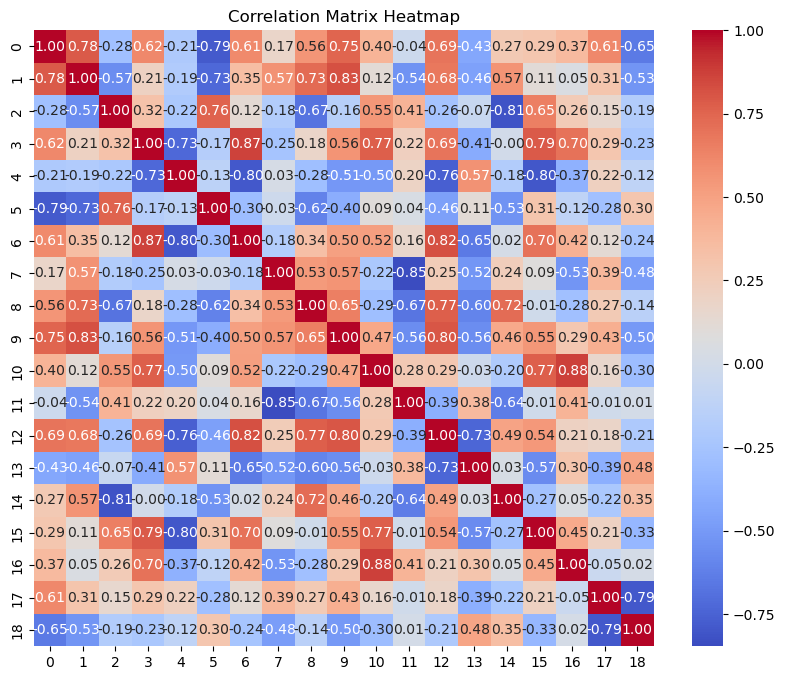

In [7]:
print(np.shape(x_top_10_candidates))
# Create subplots for the 8 histograms
fig, axes = plt.subplots(4, 5, figsize=(15, 8))  # 2 rows, 4 columns
axes = axes.flatten()  # Flatten to easily iterate
# Plot each histogram
for i in range(19):
    axes[i].hist((x_top_10_candidates[:, i]), bins=10, alpha=0.7, color='blue', edgecolor='black')
    axes[i].set_title(f"Histogram of var {i+1}")
    axes[i].set_xlabel("Value")
    axes[i].set_ylabel("Frequency")
# Adjust layout
plt.tight_layout()
plt.show()

# Compute the correlation matrix
correlation_matrix = np.corrcoef(x_top_10_candidates, rowvar=False)

import seaborn as sns
import matplotlib.pyplot as plt

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix Heatmap")
plt.show()

### Compute the ratio of measurement energy and simulation energy

In [ ]:
freq_resample = np.linspace(0, 50, 101)
FRFs_exp_ex22 = np.zeros([8,len(freq_resample)])
FRFs_exp_ex221 = np.zeros([8,len(freq_resample)])
FRFs_exp_ex220 = np.zeros([8,len(freq_resample)])
energy_FRFs_exp_ex22 = np.zeros([8])
energy_FRFs_exp_ex221 = np.zeros([8])
energy_FRFs_exp_ex220 = np.zeros([8])

i_pos_1OG = [9,10,11,12,3,13,14,15]
cut_freq_low = 4
cut_freq_high = 50

i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.sqrt((np.array([frf_data["imag_"]])[0]**2) + (np.array([frf_data["real_"]])[0]**2))

    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 50 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp_ex22[i,:] = i_resample
    energy_FRFs_exp_ex22[i] = np.sum(i_resample**2)

i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.sqrt((np.array([frf_data["imag_"]])[0]**2) + (np.array([frf_data["real_"]])[0]**2))
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 50 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp_ex220[i,:] = i_resample
    energy_FRFs_exp_ex220[i] = np.sum(i_resample**2)

i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.sqrt((np.array([frf_data["imag_"]])[0]**2) + (np.array([frf_data["real_"]])[0]**2))
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 50 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp_ex221[i,:] = i_resample
    energy_FRFs_exp_ex221[i] = np.sum(i_resample**2)

print(np.mean(energy_FRFs_exp_ex22/energy_frf_ex22,axis=0) )
print(np.mean(energy_FRFs_exp_ex221/energy_frf_ex221,axis=0))
print(np.mean(energy_FRFs_exp_ex220/energy_frf_ex220,axis=0))




### Run the simulation for comparison the optmizaed result and expiremental data
- we might need futher optimization process for fine-tunning

In [16]:
simu_tk = simulation_PyAPDL(nproc=4,nerr=10000)
simu_tk.launch_engine()
simu_tk.mapdl.clear()

PyMAPDL is taking longer than expected to connect to an MAPDL session.
Checking if there are any available licenses...
Launch Pymapdl
     Launch Pymapdl successfully, duration 15.2476 seconds.


### Fine tuning using PSO method

In [ ]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    return FRFs_simu



x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best = x_best1
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1

result = objective_function(np.array(x_best))



In [ ]:
result_norm = result/np.max(np.abs(result))
channel_1 = [0,1,2,3,8,9,10,11,16,17,18,19]
channel_2 = [4,5,6,7,12,13,14,15,20,21,22,23]

for i in range(12):
    plt.plot(freq_resample,result_norm [channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")
for i in range(12):
    plt.plot(freq_resample,result_norm [channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")

plt.show()
print(np.shape(result))
print(result)

In [ ]:
freq_resample = np.linspace(0, 50, 101)
FRFs_exp = np.zeros([24,len(freq_resample)])

i_pos_1OG = [9,10,11,12,3,13,14,15]
cut_freq_low = 8
cut_freq_high = 50

i_file = 13
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i,:] = i_resample

i_file = 1
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+8,:] = i_resample

i_file = 9
directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
for i in range(len(i_pos_1OG)):
    i_pos = i_pos_1OG[i]
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)
    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    #r = np.array([frf_data["real_"]])[0]
    imag = np.array([frf_data["imag_"]])[0]
    indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
    indices_cutoff_high = np.where((f >= 35 ))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    f = f[0:id_last]
    #r = r[0:id_last]
    imag = imag[0:id_last]
    imag[0: id_start] = 0
    imag[indices_cutoff_high[0]:id_last] = 0
    i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
    FRFs_exp[i+16,:] = i_resample

FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
for i in range(12):
    plt.plot(freq_resample,FRFs_exp_norm[channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")
for i in range(12):
    plt.plot(freq_resample,FRFs_exp_norm[channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
    plt.legend()
    plt.xlabel("freq (Hz)")
    plt.ylabel("Normalized Amplitude")

plt.show()


### Objecttive function for comparison with expirmental data

 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.616683200759068
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated
     /PREP7 finished, duration 7.4014 seconds.
Solve model: /SOLU
 Setting information
     Solution type                 :  6
     Start frequency               :  0.001
     End frequency                 :  50
     Freqency increment            :  1
     Number of modes (solu_type=2) :  40
     Damping ratio                 :  0.04443370322864978
     Excitation node               :  4160
Using Modal-superpostion method
     /SOLU finished, duration 32.4649 seconds.
 Extract all modal information , duration 5.0768 seconds.
 /POS

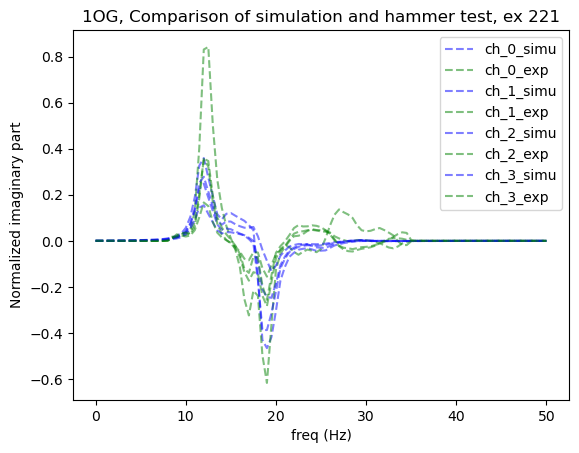

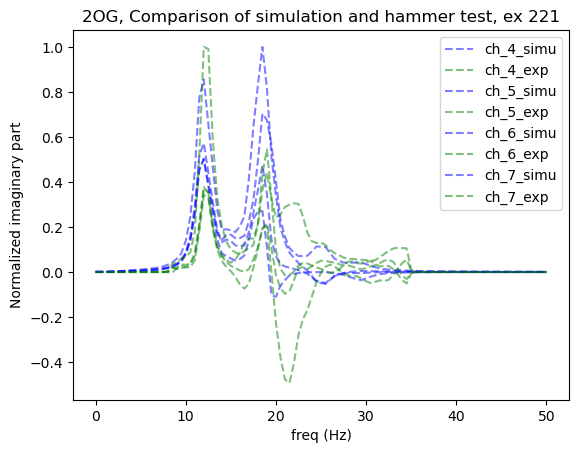

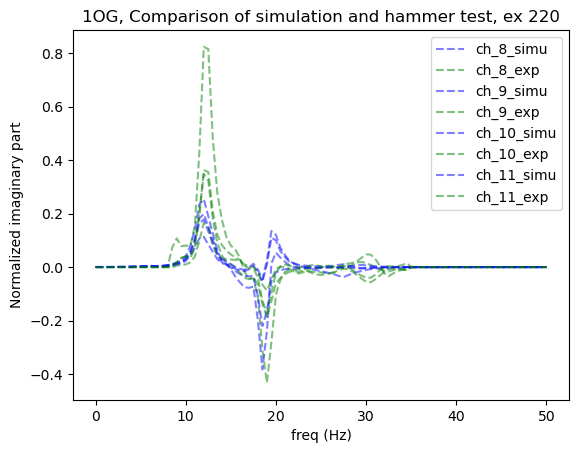

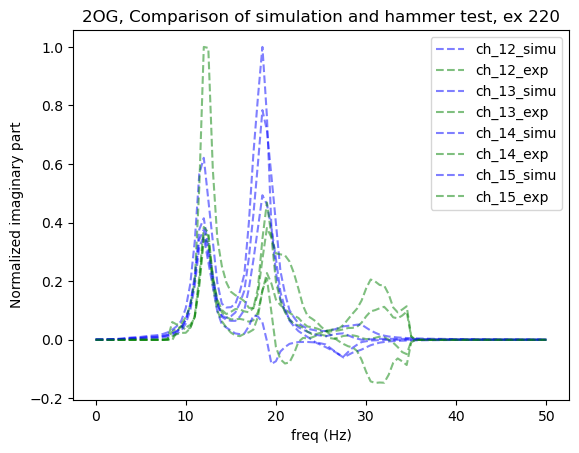

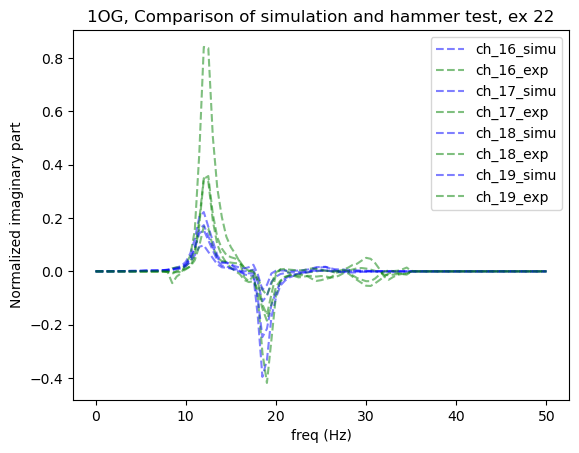

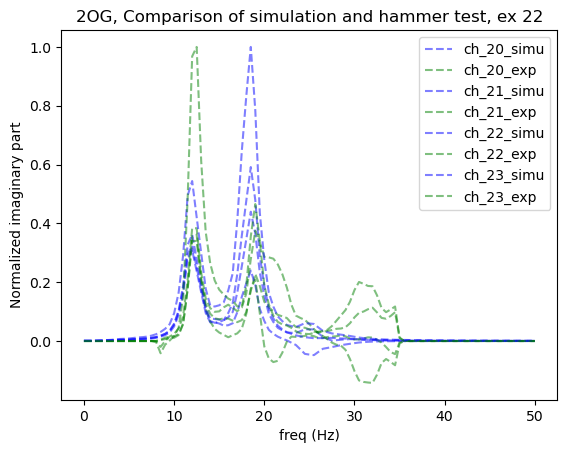

17.040106029585587
17.040106029585587


In [19]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    #clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 9
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    error_percentage = np.sum(error)
    #
    for i in range(0,4):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(4,8):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 221")
    plt.show()
    for i in range(8,12):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(12,16):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 220")
    plt.show()
    for i in range(16,20):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("1OG, Comparison of simulation and hammer test, ex 22")
    plt.show()
    for i in range(20,24):
        plt.plot(freq_resample,FRFs_simu_norm[i,:], label=f"ch_{i}_simu",linestyle="--",color='blue', alpha=0.5)
        plt.plot(freq_resample,FRFs_exp_norm[i,:], label=f"ch_{i}_exp",linestyle="--",color='green', alpha=0.5)
        plt.legend()
        plt.xlabel("freq (Hz)")
        plt.ylabel("Normalized imaginary part")
        plt.title("2OG, Comparison of simulation and hammer test, ex 22")
    plt.show()

    print(error_percentage)

    return error, error_percentage



x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_best = x_best1
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1

freq_resample = np.linspace(0, 50, 101)
for i_top_para in range(np.shape(x_top_10_candidates)[0]):
    result, error_per = objective_function(x_top_10_candidates[i_top_para,:])
#    channel_1 = [0,1,2,3,8,9,10,11,16,17,18,19]
#    channel_2 = [4,5,6,7,12,13,14,15,20,21,22,23]
#
#    for i in range(12):
#        plt.plot(freq_resample,result[channel_1[i],:], label=f"ch_{i}",linestyle="--",color='blue', alpha=0.5)
#        plt.legend()
#        plt.xlabel("freq (Hz)")
#        plt.ylabel("Normalized Amplitude")
#    plt.show()
#    for i in range(12):
#        plt.plot(freq_resample,result[channel_2[i],:], label=f"ch_{i}",linestyle="--",color='green', alpha=0.5)
#        plt.legend()
#        plt.xlabel("freq (Hz)")
#        plt.ylabel("Normalized Amplitude")
#    plt.show()
    print(error_per)



### fine-tuning using GP

#### Forming objective funciton

In [36]:
import os
from IPython.display import clear_output


def objective_function(X_input):
    X_input = np.array(X_input)
    vary_ratio = 0.5
    X_transformed = 2 * X_input - 1
    X_transformed = X_transformed.reshape(-1,1)
    X_transformed = np.transpose(X_transformed)
    i_doe = 0
    X_doe_transformed = X_transformed
    #
    # Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
    # Parameter list    = [ vs,   rho,   nu ]
    t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                        0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                        0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                        0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                        0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
    #
    e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                        20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
    #
    nu_para  = np.array([ 0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27,
                        0.27])
    #
    rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                        2300 + vary_ratio*2300*X_transformed[i_doe,11],
                        2300 + vary_ratio*2300*X_transformed[i_doe,12],
                        2300 + vary_ratio*2300*X_transformed[i_doe,13],
                        2300 + vary_ratio*2300*X_transformed[i_doe,14],
                        2300 + vary_ratio*2300*X_transformed[i_doe,10]])
    #
    soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                        1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                        0.33 ])
    #
    height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
    damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
    tol = 0.3
    #
    #
    # Start the simulation 
    simu_tk.mapdl.clear()
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.1 Pos1 (close to edge)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
    nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex221 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex221
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos2 (sensor)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
    nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex220 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex220
        }
    simu_tk.mapdl.clear()
    #
    #
    simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
    simu_tk.build_model()
    # Excitation point: Hammer 2.0 Pos1 (shaker)
    simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
    simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
    nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
    simu_tk.mapdl.nsel('ALL')
    # Apply the force on selected node and solve 
    simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
    modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
    ## Get FRF at target point
    meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
    DOE_info_ex22 = {
        'id':i_doe,
        'X':X_input.tolist(),
        'X_trans':X_doe_transformed.tolist(),
        't_info':simu_tk.t_arr.tolist(),
        'e_info':simu_tk.e_arr.tolist(),
        'n_info':simu_tk.nu_arr.tolist(),
        'r_info':simu_tk.rho_arr.tolist(),
        's_info':simu_tk.soil_arr.tolist(),
        'height':simu_tk.height,
        'dr':simu_tk.Damping_ratio,
        'modal_info':modal_info,
        'meas_frf':meas_FRFs_ex22
        }
    #
    simu_tk.mapdl.clear()
    clear_output(wait=True)
    #
    freq_resample = np.linspace(0, 50, 101)
    FRFs_simu = np.zeros([24,len(freq_resample)])
    #
    i_ch_index = 0
    ch_list = [9,10,11,12,3,13,14,15]
    # Case 221
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex221['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 220
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex220['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    # Case 22
    for i_ch in ch_list:
        imag_FRF = np.interp(freq_resample, np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['freq']), np.array(DOE_info_ex22['meas_frf'][f'disp_ch{i_ch}']['imag']).reshape(-1))
        FRFs_simu[i_ch_index,:] = imag_FRF
        i_ch_index = i_ch_index +1
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_simu)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_simu[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_simu_norm = normalized_data
    #
    #
    ####################################################################################################################################################
    # Import measurement data
    FRFs_exp = np.zeros([24,len(freq_resample)])
    #
    i_pos_1OG = [9,10,11,12,3,13,14,15]
    cut_freq_low = 8
    cut_freq_high = 50
    #
    i_file = 9
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i,:] = i_resample
    #
    i_file = 1
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+8,:] = i_resample
    #
    i_file = 13
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    for i in range(len(i_pos_1OG)):
        i_pos = i_pos_1OG[i]
        filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
        full_path = os.path.join(directory, filename)
        frf_data = sio.loadmat(full_path)
        f = np.array([frf_data["freq_"]])[0]
        #r = np.array([frf_data["real_"]])[0]
        imag = np.array([frf_data["imag_"]])[0]
        indices = np.where((f >= cut_freq_low ) & (f <= cut_freq_high))[0]
        indices_cutoff_high = np.where((f >= 35 ))[0]
        id_last = indices[-1] 
        id_start = indices[0] 
        f = f[0:id_last]
        #r = r[0:id_last]
        imag = imag[0:id_last]
        imag[0: id_start] = 0
        imag[indices_cutoff_high[0]:id_last] = 0
        i_resample = np.interp(freq_resample, f.reshape(-1), imag.reshape(-1))
        FRFs_exp[i+16,:] = i_resample
    #
    # Split into 3 groups of [8, 101]
    num_groups = 3
    group_size = 8
    normalized_data = np.zeros_like(FRFs_exp)
    #
    for i in range(num_groups):
        # Get the current group
        start_idx = i * group_size
        end_idx = start_idx + group_size
        group = FRFs_exp[start_idx:end_idx, :]  # Shape: [8, 101]
        # Compute normalization value (e.g., max of the group)
        normalization_value = np.max(group)
        # Normalize the group
        normalized_data[start_idx:end_idx, :] = group / normalization_value
    #FRFs_simu_norm = FRFs_simu/np.max(np.abs(FRFs_simu))
    FRFs_exp_norm = normalized_data
    #FRFs_exp_norm = FRFs_exp/np.max(np.abs(FRFs_exp))
    #
    #
    error = (FRFs_simu_norm - FRFs_exp_norm)**2
    error_percentage = np.sum(error)
    return error_percentage

In [ ]:
import numpy as np
from skopt import gp_minimize
from skopt.space import Real
from skopt.utils import use_named_args

# Initial guess
initial_point_best = np.mean(x_top_10_candidates, axis=0)
# Create bounds by adding/subtracting 0.5 and clamping to [0, 1]
bound = [(max(0, val - 0.25), min(1, val + 0.25)) for val in initial_point_best]
# Convert to skopt's Real dimensions for optimization
bounds = [Real(low, high, name=f"x{i}") for i, (low, high) in enumerate(bound)]
# Evaluate the objective function at these initial points
initial_values_best = objective_function(initial_point_best) 

## Also input the infromation from previous simulation
initial_points = np.vstack([X, initial_point_best])
initial_values = np.append(error_all, initial_values_best)

# Convert the objective function to use named arguments
@use_named_args(bounds)
def wrapped_objective(**params):
    return objective_function(list(params.values()))

# Run Gaussian Process Optimization
result = gp_minimize(
    func=wrapped_objective,
    dimensions=bounds,
    n_calls=50,  # Total evaluations, including initial points
    x0=initial_points.tolist(),
    y0=initial_values.tolist(),
    random_state=42
)

# Display the results
print("Best objective value:", result.fun)
print("Best parameters:")
for i, param in enumerate(result.x):
    print(f"x{i+1}: {param:.4f}")
print(result.x)

# Visualize progress of the optimization
import matplotlib.pyplot as plt
plt.plot(result.func_vals, marker='o', label="Objective Value")
plt.xlabel("Number of Iterations")
plt.ylabel("Objective Value")
plt.title("Convergence Plot")
plt.legend()
plt.show()


 Setting information
     Building inner wall           :  True
     Building stair                :  True
     Building SSI                  :  False
     Element size                  :  0.4
     Height of building            :  3.2130339514474207
 Assigning parameter
     Rewrite thickness by input
     Rewrite Young's modulus by input
     Rewrite Poisson's ratio by input
     Rewrite Density by input
     Rewrite soil properties by input
 /PREP7 activated


KeyboardInterrupt: Interrupted during MAPDL execution

### Validation from L-BFGS-B

In [36]:
import os
from IPython.display import clear_output

DOE_info = {}
vary_ratio = 0.5

x_best1 =  [ 1.0,        0.5,       0.5,           0,         0.5,        0.68722604,
            0.5,        0.5,       0.69845997,    0,         0.85229155, 0.5,
            0.5,        0.5,       0.5,           0.5,       0.5,        0.6,
            0.59828352]

x_best2 = [ 0.88901592, 0.27044889, 0.28554261, 0.01408451, 0.27367161, 0.7319021,
            0.72747765, 0.41692908, 0.21476516, 0.25659874, 0.61753642, 0.7479544,
            0.7999774 , 0.40522151, 0.62167283, 0.75864746, 0.65032564, 0.5237532,
            0.66511448]

x_oriignal = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

x_best = x_top_10_candidates[0,:]
#x_best = np.array(x_best2)
# Transform X from [0,1] to [-1,1]
#X_transformed = 2 * result.x - 1
X_transformed = 2 * x_best - 1
X_transformed = X_transformed.reshape(-1,1)
X_transformed = np.transpose(X_transformed)
i_doe = 0
X_doe_transformed = X_transformed

# Parameter list    = [slab ,corridor, ground, edge_wall, inner_wall, stair ]
# Parameter list    = [ vs,   rho,   nu ]
t_para   = np.array([ 0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0],
                      0.8  + vary_ratio*(0.8  )*X_transformed[i_doe,1],
                      0.05 + vary_ratio*(0.05 )*X_transformed[i_doe,2],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,3],
                      0.2  + vary_ratio*(0.2  )*X_transformed[i_doe,4],
                      0.468+ vary_ratio*(0.468)*X_transformed[i_doe,0]])
#
e_para   = np.array([ 20e9 + vary_ratio*20e9*X_transformed[i_doe,5],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,6],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,7],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,8],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,9],
                      20e9 + vary_ratio*20e9*X_transformed[i_doe,5]])
#
nu_para  = np.array([ 0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27,
                      0.27])
#
rho_para = np.array([ 2300 + vary_ratio*2300*X_transformed[i_doe,10],
                      2300 + vary_ratio*2300*X_transformed[i_doe,11],
                      2300 + vary_ratio*2300*X_transformed[i_doe,12],
                      2300 + vary_ratio*2300*X_transformed[i_doe,13],
                      2300 + vary_ratio*2300*X_transformed[i_doe,14],
                      2300 + vary_ratio*2300*X_transformed[i_doe,10]])
#
soil_para = np.array([ 350  + vary_ratio*(350 )*X_transformed[i_doe,15],
                       1400 + vary_ratio*(1400)*X_transformed[i_doe,16],
                       0.33 ])
#
height_b            = 3.37 + vary_ratio*3.37*X_transformed[i_doe,17]
damp_ratio_b        = 0.045+ 0.01*X_transformed[i_doe,18]
tol = 0.3

# Start the simulation 
simu_tk.mapdl.clear()
simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.1 Pos1 (close to edge)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',12.776-tol,12.776+tol)
nsel_id_3 = simu_tk.mapdl.nsel('R','LOC','Y',2.748-tol,2.748+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_3[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex221 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex221 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex221
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos2 (sensor)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',7.19-tol,7.19+tol)
nsel_id_2 = simu_tk.mapdl.nsel('R','LOC','Y',8.14-tol,8.14+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_2[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex220 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex220 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex220
    }
simu_tk.mapdl.clear()



simu_tk.setting_parameter(bool_SSI= False,height=height_b, t_arr=t_para, e_arr=e_para, nu_arr=nu_para, rho_arr=rho_para, soil_arr=soil_para)
simu_tk.build_model()
# Excitation point: Hammer 2.0 Pos1 (shaker)
simu_tk.mapdl.nsel('S','LOC','Z',simu_tk.height*2)
simu_tk.mapdl.nsel('R','LOC','X',9.3-tol,9.3+tol)
nsel_id_1 = simu_tk.mapdl.nsel('R','LOC','Y',5.9-tol,5.9+tol)
simu_tk.mapdl.nsel('ALL')
# Apply the force on selected node and solve 
simu_tk.solve_model(Solu_type=6, N_modes = 40, Freq_Incr=1, End_Freq=50,Damping_ratio= damp_ratio_b, excitation_node=nsel_id_1[1])
modal_info = simu_tk.get_all_modal_info(N_modes_exp=40)
## Get FRF at target point
meas_FRFs_ex22 = simu_tk.get_FRFs_meas_EXAMPLE()
DOE_info_ex22 = {
    'id':i_doe,
    'X':x_best.tolist(),
    'X_trans':X_doe_transformed.tolist(),
    't_info':simu_tk.t_arr.tolist(),
    'e_info':simu_tk.e_arr.tolist(),
    'n_info':simu_tk.nu_arr.tolist(),
    'r_info':simu_tk.rho_arr.tolist(),
    's_info':simu_tk.soil_arr.tolist(),
    'height':simu_tk.height,
    'dr':simu_tk.Damping_ratio,
    'modal_info':modal_info,
    'meas_frf':meas_FRFs_ex22
    }

simu_tk.mapdl.clear()
clear_output(wait=True)

print(DOE_info_ex22['t_info'])
print(DOE_info_ex22['e_info'])
print(DOE_info_ex22['r_info'])
print(DOE_info_ex22['s_info'])
print(DOE_info_ex22['height'])
print(DOE_info_ex22['dr'])




[0.6198526188125393, 0.7975940092626165, 0.0374377981274769, 0.17081695978998993, 0.22967450446996043, 0.6198526188125393]
[29999947952.634575, 11610646101.539625, 11539589197.966347, 14269969191.467354, 10869201049.644735, 29999947952.634575]
[3308.5835027552466, 2268.6969742470405, 2268.289791397962, 3449.899137495292, 2088.536611609704, 3308.5835027552466]
[422.23991585702214, 2100.0, 0.33]
4.008796155275362
0.048370004156425714


### Visualization

### Excitation 221, compare to exp 9

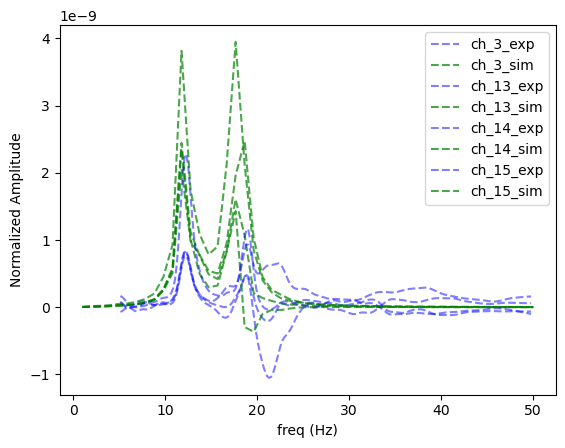

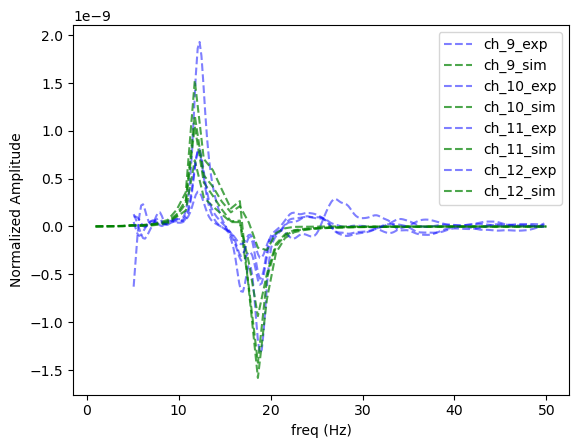

[11.9834754 11.9834754 11.9834754 11.9834754 11.9834754 11.9834754
 11.9834754 11.9834754]
11.9834754 18.14542702857143 0.7176012983957125 0.546441678869946


In [38]:
i_file = 9
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []


for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex221[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex221
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
i_ch_disp = [9,10,11,12,3,13,14,15]

mode_freq_1_list = np.zeros(len(i_ch_disp))
mode_freq_2_list = np.zeros(len(i_ch_disp))
mac_1_list = np.zeros(len(i_ch_disp))
mac_2_list = np.zeros(len(i_ch_disp))
#
#
for i_ch in range(len(i_ch_disp)):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)
print(mode_freq_1_list)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

### Excitation 220, compare to exp 1

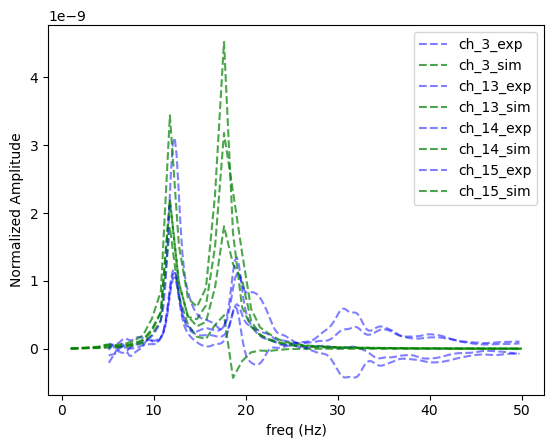

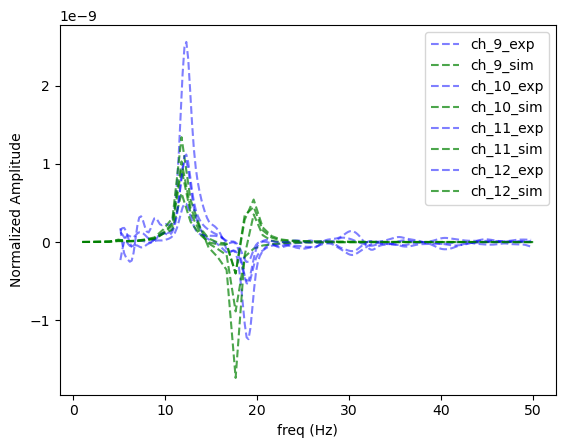

11.9834754 17.7196594 0.7124133014589458 0.7131803373888997


In [39]:
i_file = 1
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex220[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()

directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex220
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs_e = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['ampl']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )

Exictation 22, compare to exp 13

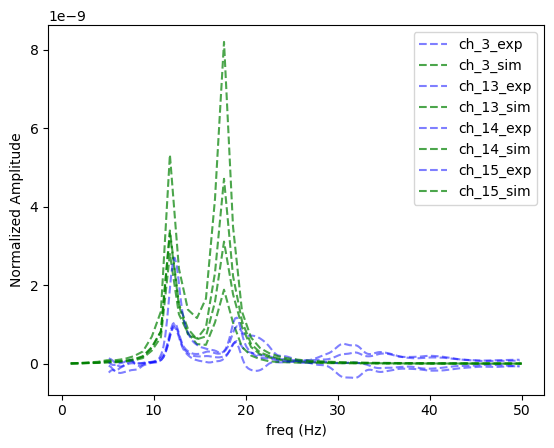

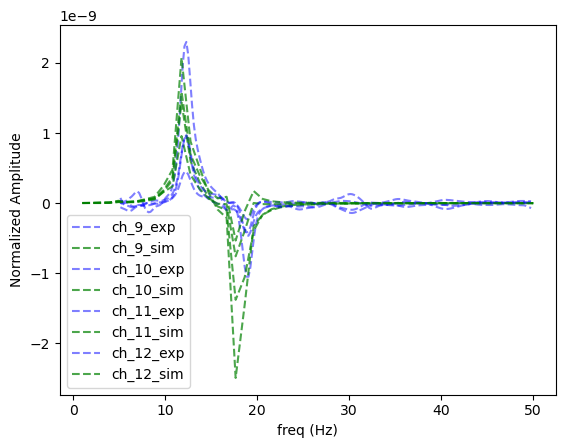

11.9834754 17.7196594 0.6031148694092576 0.5817422629974334


In [40]:
i_file = 13
#i_pos = 3
i_pos_1OG = [3,13,14,15]
cut_freq_low = 5
cut_freq_high = 50

f_1OG  = []
r_1OG  = []
i_1OG  = []

for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


i_pos_1OG = [9,10,11,12]
f_1OG  = []
r_1OG  = []
i_1OG  = []
for i in range(4):
    i_pos = i_pos_1OG[i]
    directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF"
    filename = f"FRF_test_{i_file}_ch_{i_pos}.mat"
    full_path = os.path.join(directory, filename)

    frf_data = sio.loadmat(full_path)
    f = np.array([frf_data["freq_"]])[0]
    r = np.array([frf_data["real_"]])[0]
    i = np.array([frf_data["imag_"]])[0]

    indices = np.where((f > cut_freq_low ) & (f < cut_freq_high))[0]
    id_last = indices[-1] 
    id_start = indices[0] 
    
    f = f[id_start:id_last]
    r = r[id_start:id_last]
    i = i[id_start:id_last]

    f_1OG.append(f.reshape(1, -1))  # Ensure shape is (1, N)
    r_1OG.append(r.reshape(1, -1))  # Ensure shape is (1, N)
    i_1OG.append(i.reshape(1, -1))  # Ensure shape is (1, N)

    f_1OG_mat = np.vstack(f_1OG)
    r_1OG_mat = np.vstack(r_1OG)
    i_1OG_mat = np.vstack(i_1OG)
    #i_1OG_mat = np.sqrt(np.power(i_1OG_mat,2)+np.power(r_1OG_mat,2))

max_i = np.max(abs(i_1OG_mat))
i_1OG_mat_norm = i_1OG_mat/10

for i in range(4):
    i_pos = i_pos_1OG[i]
    f_ = f_1OG_mat[i,:]
    i_norm = i_1OG_mat_norm[i,:]
    plt.plot(f_,i_norm, label=f"ch_{i_pos}_exp",linestyle="--",color='blue', alpha=0.5)
    plt.plot(meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['freq'], meas_FRFs_ex22[f'disp_ch{i_pos_1OG[i]}']['imag'], label=f"ch_{i_pos}_sim",linestyle="--",color='green', alpha=0.7)
plt.legend()
plt.xlabel("freq (Hz)")
plt.ylabel("Normalized Amplitude")
plt.show()


directory = r"D:/MDSI_project/MATLAB/Surrogate_main/FRF/"
filename = f"mode_shape_test_{i_file}.mat"
full_path = os.path.join(directory, filename)

mode_shape_exp = sio.loadmat(full_path)
mode_shape_vector_exp = mode_shape_exp['phi']
mean_fn_1_exp = np.mean(mode_shape_vector_exp[::2,0])
mean_fn_2_exp = np.mean(mode_shape_vector_exp[1::2,0])
mode_1_exp = mode_shape_vector_exp[0::2,2]
mode_2_exp = mode_shape_vector_exp[1::2,2]

ch_list = [1,2,3,7,8,9,10,11,12,13,14,15]
loaded_data = DOE_info_ex22
#
for i_ch in ch_list:
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['freq'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['real'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['imag'])
    loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'] = np.array(loaded_data['meas_frf'][f'disp_ch{i_ch}']['ampl'])
#
meas_FRFs = loaded_data['meas_frf']
#
natrual_freq = []
for i_mode in range(1,len(loaded_data['modal_info'])):
    natrual_freq.append(loaded_data['modal_info'][f'modal_info_{i_mode}']['modal_freq'])
#
mode_freq_vector, mode_shape_vector = extract_mode_shape_vector(natrual_freq,meas_FRFs  )
#print(mode_freq_vector, mode_shape_vector)
#
mode_freq_1_list = np.zeros(8)
mode_freq_2_list = np.zeros(8)
mac_1_list = np.zeros(8)
mac_2_list = np.zeros(8)
#
i_ch_disp = [9,10,11,12,3,13,14,15]
for i_ch in range(8):
#
    [index_1, index_2], [mode_freq_1_list[i_ch],mode_freq_2_list[i_ch]] = find_peaks_SDOFsup(2,mode_freq_vector,meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['freq'], abs( meas_FRFs[f'disp_ch{i_ch_disp[i_ch]}']['imag']),0.05)
    mac_1_list[i_ch] = get_MAC(mode_shape_vector[int(index_1),:],mode_1_exp)
    mac_2_list[i_ch] = get_MAC(mode_shape_vector[int(index_2),:],mode_2_exp)
#
f_n_1_mean = mean_value_filted(mode_freq_1_list,1)
f_n_2_mean = mean_value_filted(mode_freq_2_list,1)
mac_1_mean = mean_value_filted(mac_1_list,1)
mac_2_mean = mean_value_filted(mac_2_list,1)


print(f_n_1_mean,f_n_2_mean,mac_1_mean,mac_2_mean )